In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
def EnhanceContrast(img, alpha, beta):
    new_img = np.zeros((img.shape[0], img.shape[1]))
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            new_img[y,x] = np.clip(alpha*img[y,x] + beta, 0, 255)
    return new_img

In [3]:
def DetectEdges(img, IsTemplate=False):
    if IsTemplate :
        canny = cv2.Canny(img, 60, 120)
    else :
        blur = cv2.GaussianBlur(img,(13,13),0)
        canny = cv2.Canny(blur,40,80)
    return canny

In [4]:
def MatchTemplate(img, template, methods):
    img_w, img_h = img.shape[::-1]
    tmp_w, tmp_h = template.shape[::-1]
    seed = img.copy()
    candidates = []
    scales = np.linspace(1, 3, 20)
    top_lefts = []
    bottom_rights = []
    scores = []
    
    for meth in methods:
        method = eval(meth)
        for scale in scales:
            candidates.append(cv2.resize(seed,(int(scale*img_w), int(scale*img_h)), interpolation = cv2.INTER_CUBIC))

        for candidate in candidates:
            candidate_w, candidate_h = candidate.shape[::-1]
            if (tmp_w >= candidate_w or tmp_h >= candidate_h):
                scores.append(0)
                top_lefts.append(0)
                bottom_rights.append(0)
                continue

            res = cv2.matchTemplate(candidate, template, method)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            scales[candidates.index(candidate)], max_val

            top_left = max_loc
            bottom_right = (top_left[0] + tmp_w, top_left[1] + tmp_h)
            top_left = (top_left[0], top_left[1])

            candidate_copy = candidate.copy()
            cv2.rectangle(candidate_copy, top_left, bottom_right, 255, 2)

            scores.append(max_val)
            top_lefts.append(top_left)
            bottom_rights.append(bottom_right)

        max_idx = scores.index(max(scores))
        scale = scales[max_idx]
        top_left = top_lefts[max_idx]
    return scale, top_left

In [5]:
def SuperimposeMask(raw_l_img, s_img, top_left, scale): 
    
    raw_l_img_h, raw_l_img_w, raw_l_img_c = raw_l_img.shape
    l_img = cv2.resize(raw_l_img, (int(scale*raw_l_img_w), int(scale*raw_l_img_h)), interpolation=cv2.INTER_CUBIC)
    
    x_offset = top_left[0]
    y_offset = top_left[1]
    
    x1, x2 = x_offset, x_offset + s_img.shape[1]
    y1, y2 = y_offset, y_offset + s_img.shape[0]
    
    alpha_s = s_img[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s
    
    for c in range(0, 3):
        l_img[y1:y2, x1:x2, c] = (alpha_s * s_img[:, :, c] +
                                  alpha_l * l_img[y1:y2, x1:x2, c])

    return l_img


In [6]:
''' Contour Index
0: lower right, outer
2: lower left, outer
4: rectangle, outer

Cx = M10 / M00
Cy = M-1 / M00
'''

def ComputerCenterInTemplate(img_original):
    img = img_original.copy()
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2, contours, hierarchy = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # compute centroids of two circles and one rectangle
    centroids = []
    for i in [0, 2, 4]:
        cnt = contours[i]
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        centroids.append((cx, cy))
    
    # clear img
    img[:] = (0,0,0)
    
    # connect three centroids
    cv2.line(img, centroids[0], centroids[1], (0,0, 255), 3)
    cv2.line(img, centroids[1], centroids[2], (0,0, 255), 3)
    cv2.line(img, centroids[2], centroids[0], (0,0, 255), 3)
    
    # compute the centroid of triangle
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2, contours, hierarchy = cv2.findContours(imgray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt=contours[0]
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return (cx, cy)

In [7]:
def ComputeCenterInImg(scale, top_left, tmp_c):
    cx_scaled = top_left[0] + tmp_c[0]
    cy_scaled = top_left[1] + tmp_c[1]
    cx = int(cx_scaled / scale)
    cy = int(cy_scaled / scale)
    return (cx_scaled, cy_scaled)

/home/jia/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


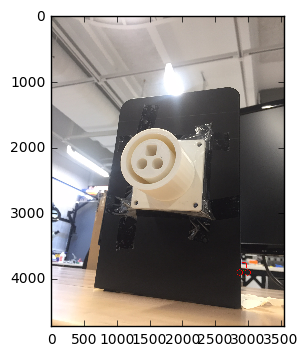

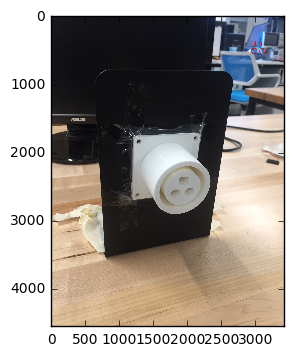

In [8]:
os.chdir("/home/jia/ev_charge/img2/")

# read template
template = cv2.imread("./masks/mask_no_perimeter.png")
template_thick = cv2.imread("./masks/mask_no_perimeter_thick.png", -1)

# compute template center
tmp_center = ComputerCenterInTemplate(template)

img_idx_list = list(range(0, 2))

for img_idx in img_idx_list:

    # read image
    img = cv2.imread("./sockets/socket"+str(img_idx)+".jpg")
    img_gray = cv2.imread("./sockets/socket"+str(img_idx)+".jpg", 0)
    
    # edge detection
    img_canny = DetectEdges(img_gray, img_idx)
    template_canny = DetectEdges(template, IsTemplate=True)
    cv2.imwrite("./canny/raw_canny"+str(img_idx)+".jpg", img_canny)
    cv2.imwrite("./canny/template_canny.jpg", template_canny)

    # matching
    scale, top_left = MatchTemplate(img_canny, template_canny, ["cv2.TM_CCOEFF"])

    # superimpose mask
    demo = SuperimposeMask(img, template_thick, top_left, scale)
    
    # compute socket center
    socket_center = ComputeCenterInImg(scale, top_left, tmp_center)
    cv2.circle(demo, socket_center, 2, (0,255,0), thickness=10)
    
    cv2.imwrite("./results/demo"+str(img_idx)+".jpg", demo)
